### $\color{royalblue}{\text{ Sedma vježba iz numeričkih metoda u astronomiji (NMA), datum: 5.12.2024.}} $

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
from mpl_toolkits.mplot3d import Axes3D

### $\color{magenta}{\text{1. NUMERIČKA INTEGRACIJA DIFERENCIJALNIH JEDNAČINA.}} $

Od ranije je poznato da je Tejlorovim redovima moguće funkciju aproksimirati pomoću polinoma, koristeći vrijednost funkcije i njenih izvoda u određenoj tački:
#### $f(x+\Delta x)=f(x)+\Delta x\cdot f'(x)+\frac{1}{2}(\Delta x)^2\cdot f''(x)+...$
U Ojlerovoj metodi, pretpostavka je da je korak $\Delta x$ dovoljno mali tako da su doprinosi od viših izvoda zanemarljivi.
Primjer: jednačine kretanja.
#### $\vec{r}(t+\Delta t)\approx\vec{r}(t)+\Delta t\cdot\vec{v}(t)$,
#### $\vec{v}(t+\Delta t)\approx\vec{v}(t)+\Delta t\cdot\vec{a}(t)$.
Poznavanjem položaja, brzine i ubrzanja u nekom trenutku vremena možemo da izračunamo njihove vrijednosti u 
nekom budućem trenutku.

Pretpostavka je da su poznati početni uslovi (položaj i brzina). Takođe, poznate su sile koje djeluju, kao i masa, te je moguće izračunati ubrzanje.

Ispod je kod za kreiranje raznih korisnih konverzionih funkcija. Još važnije, data je funkcija

koja računa komponente ubrzanja nekog tijela koje je pod uticajem gravitacije Sunca i planete (potrebno nešto kasnije).

### 1.1. Ojlerova metoda.

In [21]:
def year2second(x): # konverzija godina u sekunde
    return x*31557600.0

def day2second(x): # konverzija dana u sekunde
    return x*86400

def second2day(x): # konverzija sekunda u dane
    return x/86400

def second2year(x): # konverzija sekunda u godine
    return x/31557600.0

def au2m(x): # konverzija astronomskih jedinica u metre
    return x*au

def m2au(x): # konverzija metara u astronomske jedinice
    return x/au

def ubrzanje_3tijela(x,y,z,xp,yp,zp,Ms,Mp, gama):
    
    # x,y,z - heliocentrične koordinate objekta
    # xp,yp,zp - heliocentrične koordinate planete
    # Ms - masa Sunca
    # Mp - masa planete
    # gama - gravitaciona konstanta
    
    x_pc=x-xp
    y_pc=y-yp
    z_pc=z-zp
    
    r=(x ** 2 + y ** 2 + z ** 2)**(1/2) # heliocentični radijus vektor objekta
    r_pc=(x_pc ** 2 + y_pc ** 2 + z_pc** 2)**(1/2) # planetocentrični radijus vektor objekta


    ax = -gama * (Ms / r**3 * x + Mp / r_pc**3 * x_pc)
    ay = -gama * (Ms / r**3 * y + Mp / r_pc**3 * y_pc)
    az = -gama * (Ms / r**3 * z + Mp / r_pc**3 * z_pc)
    
    return ax, ay, az

gm=1.32712440018e20 # gravitaciona konstanta * masa Sunca
au=149597870700.

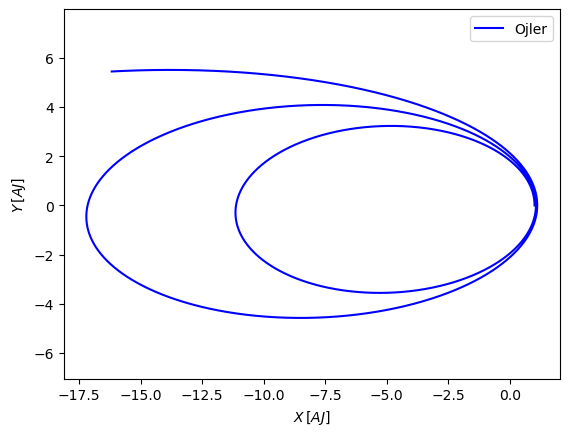

In [26]:
x=[au2m(1)] # početni položaji
y=[0]
z=[0]

vx=[0] # početne brzine
vy=[4e4] 
vz=[0]

t=year2second(50) # parametri integracije
dt=day2second(1)

tt=0

while tt<t:
    
    r=np.sqrt(x[-1]**2+y[-1]**2+z[-1]**2) #trenutno heliocentrično rastojanje
    
    # komponente ubrzanja
    ax=-gm/r**3*x[-1]
    ay=-gm/r**3*y[-1]
    az=-gm/r**3*z[-1]
    
    # koordinate
    x.append(x[-1]+vx[-1]*dt)
    y.append(y[-1]+vy[-1]*dt)
    z.append(z[-1]+vz[-1]*dt)
    
    # brzine
    vx.append(vx[-1]+ax*dt)
    vy.append(vy[-1]+ay*dt)
    vz.append(vz[-1]+az*dt)
    
    # vrijeme
    tt=tt+dt
    
plt.plot(m2au(np.array(x)), m2au(np.array(y)),'b', label='Ojler')
plt.axis('equal')
plt.xlabel(r'$X\,[AJ]$')
plt.ylabel(r'$Y\,[AJ]$')
plt.legend()
plt.show()

#### Komentar: Ojlerova metoda može akumulirati grešku tokom duže simulacije, posebno kod orbita koje bi trebalo
#### da budu eliptične. Ta greška se može pojaviti kao "spiralni" odmak orbite.

### 1.2. Ojler-Kromerova metoda.
Modifikacija klasične Ojlerove metode, a glavna razlika je u redosljedu ažuriranja brzina i položaja.

Prvo se ažurira brzina, a položaj se računa iz ažurirane brzine, što daje stabilnije rješenje.
#### $\vec{v}(t+\Delta t)\approx\vec{v}(t)+\Delta t\cdot\vec{a}(t)$.
#### $\vec{r}(t+\Delta t)\approx\vec{r}(t)+\Delta t\cdot\vec{v}(t+\Delta t)$,

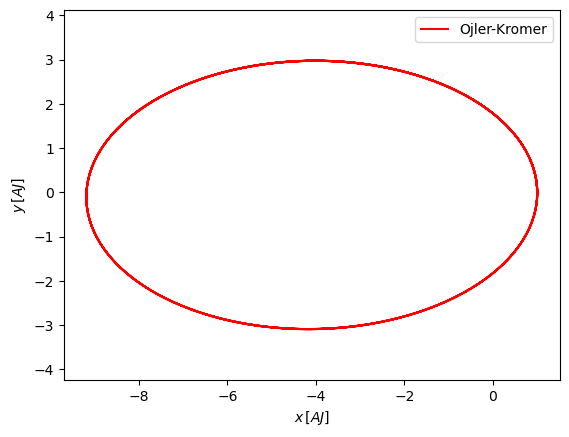

In [27]:
x=[au2m(1)] # #početni uslovi
y=[0]
z=[0]

vx=[0] # početne brzine
vy=[4e4]
vz=[0]

tt=0
dt=day2second(1)
while tt<t:
    
    r=np.sqrt(x[-1]**2+y[-1]**2+z[-1]**2) #trenutno heliocentrično rastojanje
    
    # komponente ubrzanja
    ax=-gm/r**3*x[-1]
    ay=-gm/r**3*y[-1]
    az=-gm/r**3*z[-1]
    
    # brzine
    vx.append(vx[-1]+ax*dt)
    vy.append(vy[-1]+ay*dt)
    vz.append(vz[-1]+az*dt)
    
    # koordinate
    x.append(x[-1]+vx[-1]*dt)
    y.append(y[-1]+vy[-1]*dt)
    z.append(z[-1]+vz[-1]*dt)
    
    # vrijeme
    tt=tt+dt
    
plt.plot(m2au(np.array(x)), m2au(np.array(y)),'r', label='Ojler-Kromer')
plt.axis('equal')
plt.legend()
plt.xlabel('$x\,[AJ]$')
plt.ylabel('$y\,[AJ]$')
plt.legend()
plt.show()

Ojlerova metoda je inferiorna u odnosu na Ojler-Kromerovu metodu jer je nestabilna za velike korake $\Delta t$

i akumulira greške u oscilatornim sistemima. Obje metode su jako jednostavne za primjenu.

### 1.3. Složeniji slučaj.
Sada imamo dva gravitaciona izvora – Sunce i Zemlju. Simulira se putanja tijela zanemarljive mase pod njihovim uticajem.

Uvedene su geocentrične koordinate za praćenje položaja tijela u odnosu na Zemlju ($x_{gc},\,y_{gc},\,z_{gc}$), 

dok su heliocentrične koordinate ($x_{hc},\,y_{hc},\,z_{hc}$) praćene u odnosu na Sunce.


In [50]:
Ms = 1.989e30 # masa Sunca
Mz = 5.972e24 # masa Zemlje
gama = 6.67e-11 # gravitaciona konstanta
r0z = 6.378e6  # poluprečnik Zemlje
v_zemlja = 2 * np.pi * au2m(1.) / (365.25 * 86400) # brzina Zemlje

v0 = 1e3 # početna brzina u odnosu na Zemlju

x_hc = [au2m(1.) + 50 * r0z] # 50 Zemljinih poluprečnika od Zemlje
y_hc = [0]
z_hc = [0]
vx_hc = 0
vy_hc = v_zemlja+v0 # heliocentrična brzina tijela
vz_hc = 0

print(x_hc)

[149916770700.0]


In [51]:
xz = au2m(1) # koordinate Zemlje
yz = 0
zz = 0

sk = 2 * np.pi / year2second(1) # ugaona brzina kretanja Zemlje oko Sunca

x_gc = [x_hc[0] - xz] # geocentrične koordinate objekta
y_gc = [y_hc[0] - yz]
z_gc = [z_hc[0] - zz]

dt = day2second(1/24/6) # korak integracije
t = 0 # početno vrijeme

while t < year2second(1):

    r_hc=(x_hc[-1] ** 2 + y_hc[-1] ** 2 + z_hc[-1] ** 2)**(1/2)
    r_gc=(x_gc[-1] ** 2 + y_gc[-1] ** 2 + z_gc[-1] ** 2)**(1/2)

    ax = -gama * (Ms / r_hc**3 * x_hc[-1] + Mz / r_gc**3 * x_gc[-1])
    ay = -gama * (Ms / r_hc**3 * y_hc[-1] + Mz / r_gc**3 * y_gc[-1])
    az = -gama * (Ms / r_hc**3 * z_hc[-1] + Mz / r_gc**3 * z_gc[-1])

    vx_hc += ax * dt
    vy_hc += ay * dt
    vz_hc += az * dt

    x_hc.append(x_hc[-1] + vx_hc * dt)
    y_hc.append(y_hc[-1] + vy_hc * dt)
    z_hc.append(z_hc[-1] + vz_hc * dt)

    lz = t * sk  # longituda Zemlje 

    # pravougle koordinate Zemlje
    xz = au2m(1.) * np.cos(lz)
    yz = au2m(1.) * np.sin(lz)

    # geocentrične koordinate objekta
    x_gc.append(x_hc[-1] - xz)
    y_gc.append(y_hc[-1] - yz)
    z_gc.append(z_hc[-1] - zz)
    
    t += dt

x_hc = np.array(x_hc)
y_hc = np.array(y_hc)
z_hc = np.array(z_hc)

x_gc = np.array(x_gc)
y_gc = np.array(y_gc)
z_gc = np.array(z_gc)

Dodatno pojašnjenje prije plotovanja:

Pretpostavlja se da Zemlja kruži oko Sunca po idealnoj kružnoj orbiti sa poluprečnikom od $1\,AJ$. Dakle, njen položaj se može predstaviti kao:

#### $x=r\cos{\theta},\,y=r\sin{\theta}$,

gdje je $\theta$ trenutna longituda koja se računa kao $\theta=t\cdot sk$, $sk=\frac{2\pi}{god}$, a $sk$ je ugaona brzina Zemlje oko Sunca,

jer Zemlja obiđe $2\pi$ radijana za jednu godinu. Takođe, ovdje se godina konvertuje u sekunde.

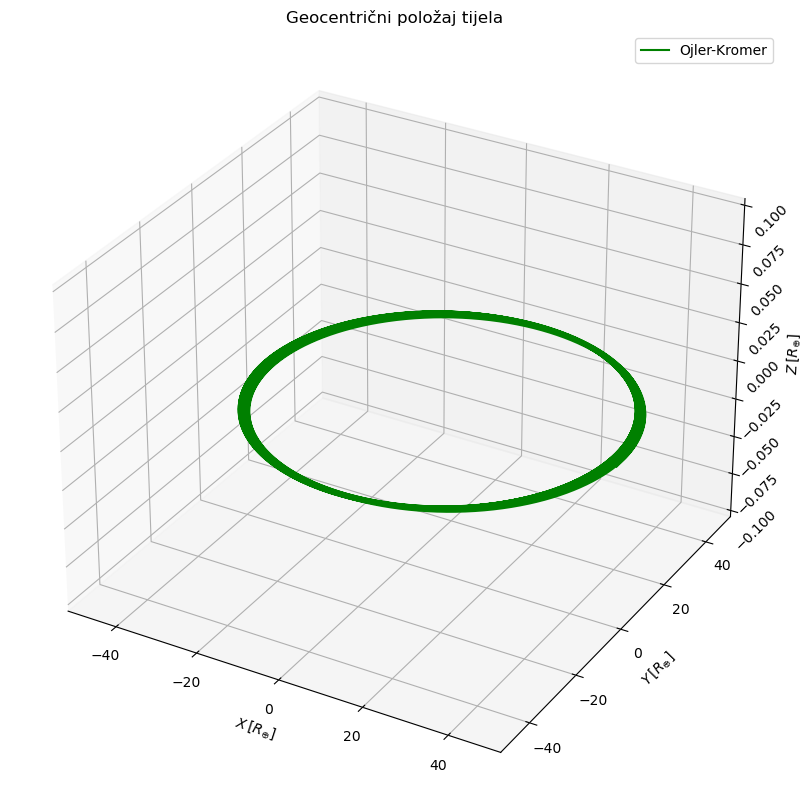

In [75]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_gc/r0z,y_gc/r0z,z_gc/r0z, color='g', label='Ojler-Kromer')
ax.set_xlabel(r'$X\,[R_{\oplus}]$')
ax.set_ylabel(r'$Y\,[R_{\oplus}]$')
ax.set_zlabel(r'$Z\,[R_{\oplus}]$')

ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_zlim(-0.1, 0.1)

ax.zaxis.set_tick_params(labelsize=10, labelrotation=45)
plt.tight_layout()
plt.title('Geocentrični položaj tijela')
plt.legend()
plt.show()

### 1.4. Zaključak:
Ojlerova metoda je najjednostavnija metoda za rješavanje diferencijalnih jednačina, a veoma se lako implementira.

Korisna je u slučaju kad je potreban "grub" uvid u dinamiku sistema. Međutim, ima dosta nedostataka,

poput neočuvanja energije u konzervativnim sistemima. Položaj se računa na osnovu trenutne brzine, a ta brzina

nije korigovana efektima ubrzanja tokom cijelog koraka, pa se greška akumulira. Ojlerova metoda se pak,

može koristiti za sisteme koji nisu konzervativni (npr. gdje postoji prigušenje). Ojler-Kromerova metoda

bolje očuva konzervativne osobine sistema (energiju i ugaoni moment), a kod orbita, to znači da će tijelo

nastaviti da kruži oko Sunca ili Zemlje bez "spiralnog" napuštanja orbite.